In [1]:
import pandas as pd
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('../results/model_params_and_results.csv')

In [3]:
df['score'] = df['score']*-1 # Converting negative MSE to positive MSE

In [4]:
df

,num_hidden_layers,hidden_layer_size,activation_function,score
0,0,0,linear,2.584747
1,0,0,relu,7.227311
2,0,0,sigmoid,3.625803
3,0,0,tanh,3.625803
4,1,64,linear,0.289578
5,1,64,relu,0.497862
6,1,64,sigmoid,0.297948
7,1,64,tanh,0.310448
8,1,128,linear,0.279975
9,1,128,relu,0.259806


We can now look at some descriptive statistics for different parameters.

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ba4aa58>]], dtype=object)

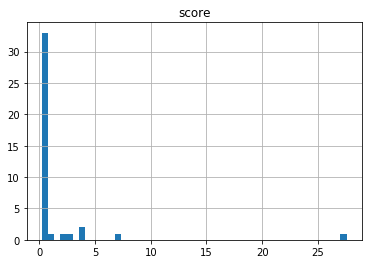

In [6]:
pd.DataFrame.hist(data=df, column='score',bins=50)

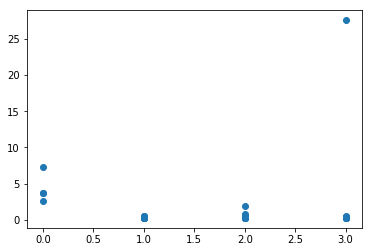

In [7]:
plt.scatter(x=df.num_hidden_layers, y=df.score)

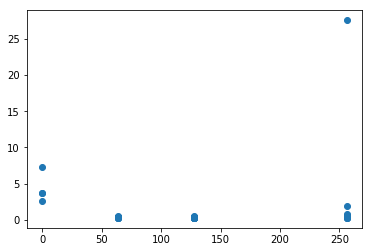

In [8]:
plt.scatter(x=df.hidden_layer_size, y=df.score)

In [9]:
df.head()

,num_hidden_layers,hidden_layer_size,activation_function,score
0,0,0,linear,2.584747
1,0,0,relu,7.227311
2,0,0,sigmoid,3.625803
3,0,0,tanh,3.625803
4,1,64,linear,0.289578


In [10]:
activation_dummies = pd.get_dummies(df.activation_function)

In [11]:
df['layers_and_size_interaction'] = df.num_hidden_layers + df.hidden_layer_size

In [12]:
df = pd.concat([df,activation_dummies],axis=1)

In [13]:
df.columns

Index(['num_hidden_layers', 'hidden_layer_size', 'activation_function',
       'score', 'layers_and_size_interaction', 'linear', 'relu', 'sigmoid',
       'tanh'],
      dtype='object')

Now to run an OLS model

In [14]:
model = smf.ols(formula='score ~ num_hidden_layers + hidden_layer_size + layers_and_size_interaction \
                + relu + sigmoid + tanh', data=df)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                 -0.056
Method:                 Least Squares   F-statistic:                    0.5854
Date:                Mon, 02 Oct 2017   Prob (F-statistic):              0.711
Time:                        15:58:39   Log-Likelihood:                -114.24
No. Observations:                  40   AIC:                             240.5
Df Residuals:                      34   BIC:                             250.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

None of the coefficients are significant, making it difficult to interpret the results of the model. Overall it appears that all of the activation functions have a stronger negative effect on mean squared error (thus improving the predictions) than the reference category, the linear activation function. The number of hidden layers and the interaction between this and the hidden layer size (the number of neurons in the layer) are both also negative, which hidden layer size alone is positive.

An issue with the current data is that the outliers with extremely high MSE, where the model was never able to converge towards sensible predictions, may be biasing the results. To assess whether this is the case I can re-run the models excluding these outliers.

In [15]:
df_ = df[df['score'] <= 1.0]

In [16]:
df_.shape

(34, 9)

In [17]:
model = smf.ols(formula='score ~ num_hidden_layers + hidden_layer_size + layers_and_size_interaction \
                + relu + sigmoid + tanh', data=df_)

results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     3.352
Date:                Mon, 02 Oct 2017   Prob (F-statistic):             0.0170
Time:                        15:58:39   Log-Likelihood:                 32.054
No. Observations:                  34   AIC:                            -52.11
Df Residuals:                      28   BIC:                            -42.95
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Here we see that the overall model fit has improved, with the R-squared value increasing from 0.079 to 0.374. The coefficient for the ReLU activation is also positive now, consistent with the observation that its performance tends to fluctuate more than the other functions.

Overall these results show that there are no clear, statistically significant, effects of basic architecture on model performance. Nonetheless the observed differences in the results elsewhere provide some evidence that models with more layers and node and non-linear activation are better able to generalize to out-of-sample data. The small number of observations may also be preventing us from seeing statistically significant relationships. Future work should assess the performance of models over a greater range of architectures to better assess how these choices affect predictive performance.